# Business Understanding

I'm interested in investing in a property in Edinburgh that I would use as a holiday rental on AirBnB. I want to maximise the returns on my investment, so I'm interested in understanding the factors that affect prices. In particular:

1. What features affect price? 
2. What neighbourhoods are strong predictors of price? 
2. Are there any amenities I definitely must have? 
3. Do I invest in an entire property or room or maybe a house?  

The source data is available here: http://data.insideairbnb.com/united-kingdom/scotland/edinburgh/2021-02-11/data/listings.csv.gz

In [1]:
# imports

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

from sklearn.model_selection import train_test_split

from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, MultiLabelBinarizer

from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

#Import scoring metrics
from sklearn.metrics import mean_squared_error, r2_score

pd.options.display.max_rows = 999
pd.set_option('display.max_colwidth', 200)
pd.set_option('display.float_format', '{:.5f}'.format) # suppress scientific notation

# Data Understanding

In [2]:
# load data
# look at the shape of the data and the raw data

list_df = pd.read_csv('./Data/listings.csv')
display(list_df.shape)

(6536, 74)

In [3]:
# find columns with missing data as percentage. 
# those that are missing 100% will be dropped for sure. 

print( (list_df.isnull().sum() / len(list_df) * 100).sort_values(ascending=False))


bathrooms                                      100.00000
license                                        100.00000
neighbourhood_group_cleansed                   100.00000
calendar_updated                               100.00000
host_neighbourhood                              44.23195
host_response_time                              40.80477
host_response_rate                              40.80477
host_about                                      40.29988
neighborhood_overview                           25.36720
neighbourhood                                   25.36720
host_acceptance_rate                            21.66463
review_scores_checkin                           15.48348
review_scores_location                          15.48348
review_scores_value                             15.48348
review_scores_accuracy                          15.46818
review_scores_cleanliness                       15.46818
review_scores_communication                     15.46818
review_scores_rating           

array([[<AxesSubplot:title={'center':'id'}>,
        <AxesSubplot:title={'center':'scrape_id'}>,
        <AxesSubplot:title={'center':'host_id'}>,
        <AxesSubplot:title={'center':'host_listings_count'}>,
        <AxesSubplot:title={'center':'host_total_listings_count'}>,
        <AxesSubplot:title={'center':'neighbourhood_group_cleansed'}>],
       [<AxesSubplot:title={'center':'latitude'}>,
        <AxesSubplot:title={'center':'longitude'}>,
        <AxesSubplot:title={'center':'accommodates'}>,
        <AxesSubplot:title={'center':'bathrooms'}>,
        <AxesSubplot:title={'center':'bedrooms'}>,
        <AxesSubplot:title={'center':'beds'}>],
       [<AxesSubplot:title={'center':'minimum_nights'}>,
        <AxesSubplot:title={'center':'maximum_nights'}>,
        <AxesSubplot:title={'center':'minimum_minimum_nights'}>,
        <AxesSubplot:title={'center':'maximum_minimum_nights'}>,
        <AxesSubplot:title={'center':'minimum_maximum_nights'}>,
        <AxesSubplot:title={'cent

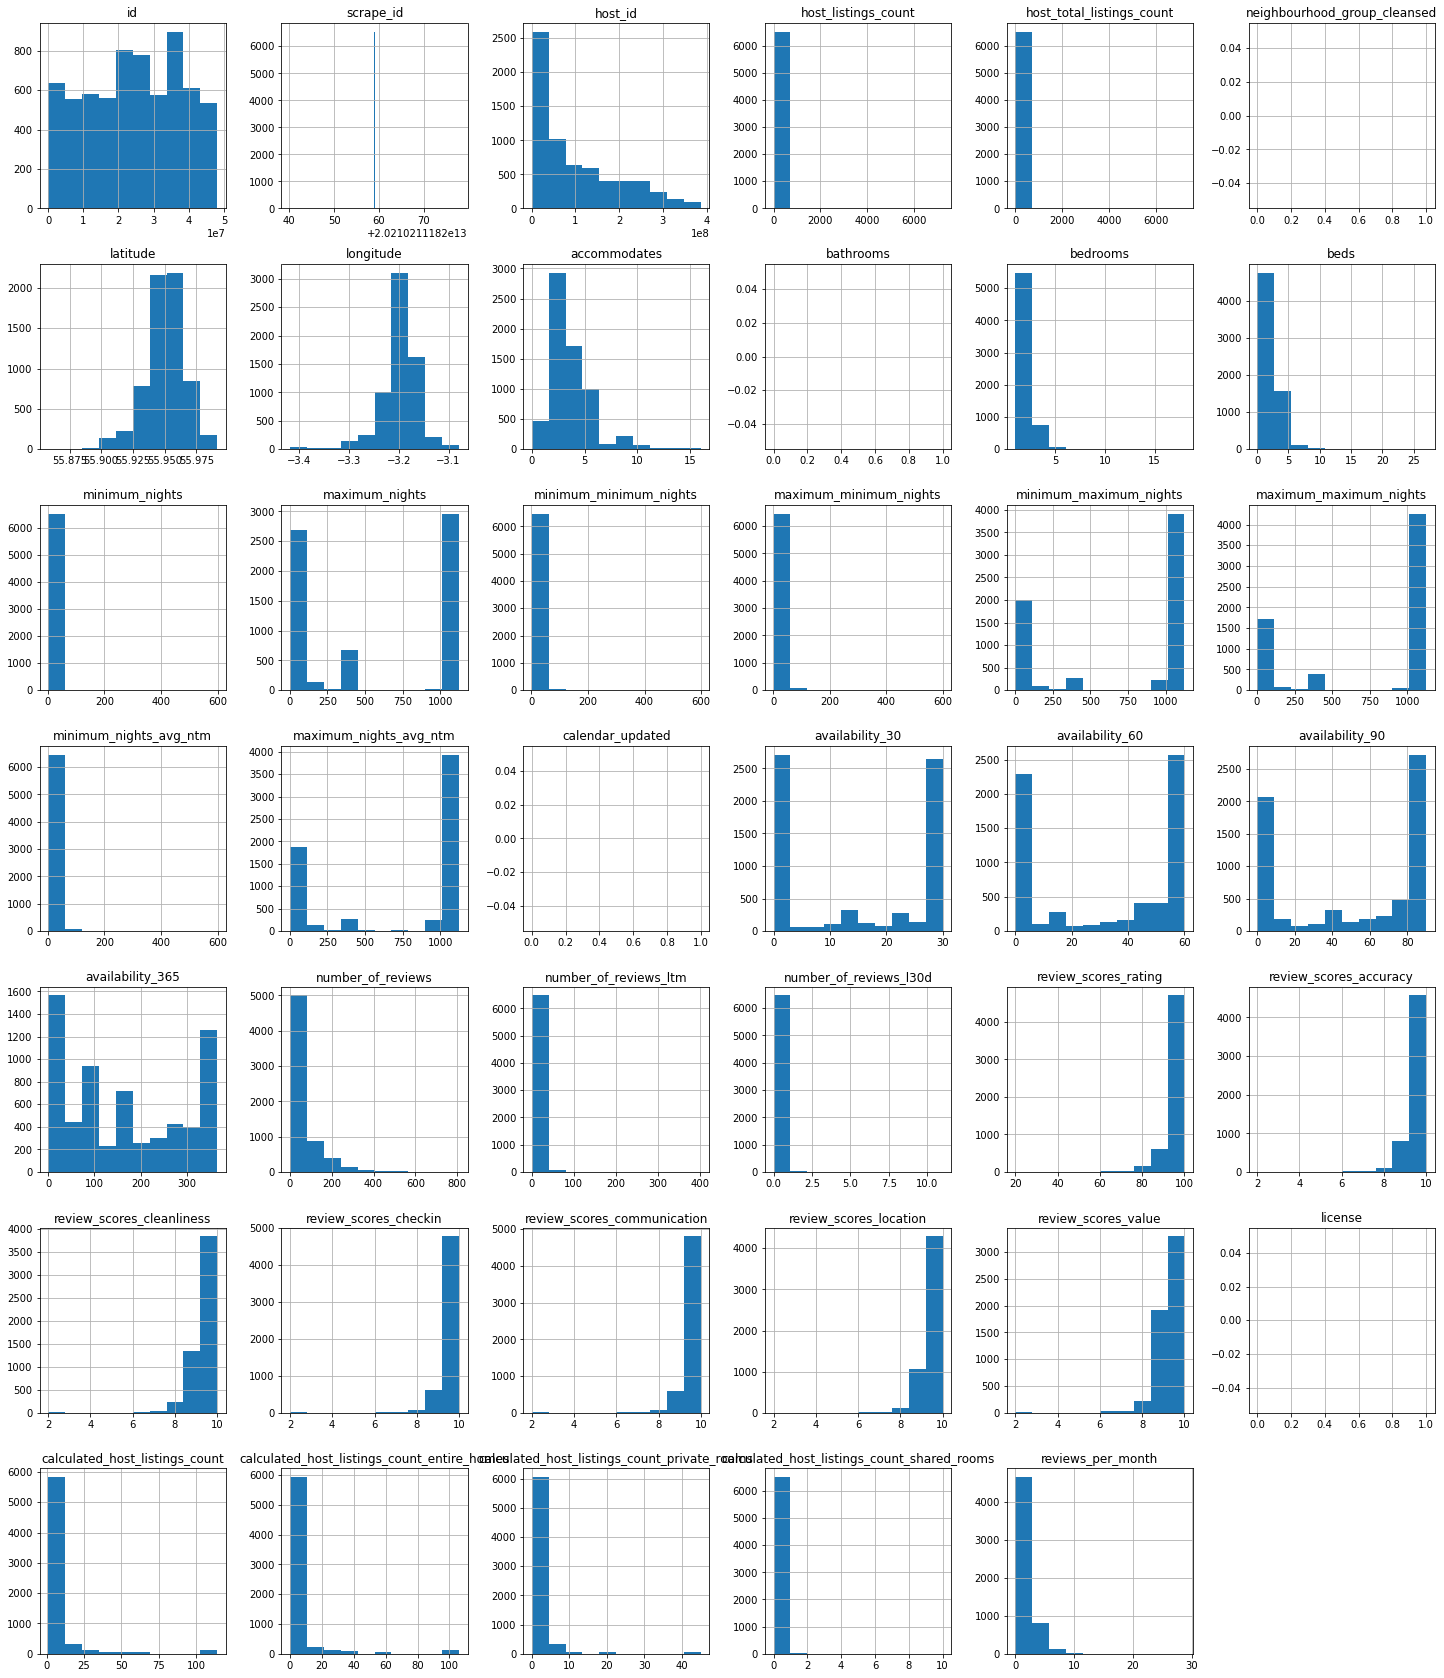

In [4]:
# Plot distributions to visually inspect data

list_df.hist(figsize = (25,30))

# Data Preparation

I need to process the data to be able to fit and run a model. In particular:

* 'price', the variable I want to predict, is a string which I'll convert to a float
* 'bathrooms_text': contains the number of bathrooms, I'll split this into two columns: number of bathrooms and whether it's shared. 
* Columns that I'll drop follow into those categories:
    * columns irrelevant for the business question: e.g., urls, instantly bookable, available now etc. 
    * columns related to personal information (like pictures, host names, host location etc) that might lead to a biassed model and hence raise ethical concerns. 
    * columns that would cause data leakage: e.g., review information that cannot be known in advance. 
    * columns that have missing values: 'bathrooms', 'license', 'neighbourhood_group_cleansed' and 'calendar_updated' 
    * columns that have mostly one value and cannot have any predictive power : e.g., 'minimum_nights_avg_ntm', 'calculated_host_listings_count_shared_rooms'
    * columns that are strongly correlated with other features: e.g., 'beds'
  
* 'amenities' is an important feature for the task, this will be binarised to be able to use for modelling. 


## 'Price' feature (our target)

In [5]:
# 'convert' price to a float & strip off the '$' sign

list_df['price'] = list_df['price'].replace('[\$,]', '', regex=True).astype(float)

## 'Bathrooms_text' feature

In [6]:
# function to process 'bathrooms_text' variable: returns the number of the bathrooms, if a number there, otherwise '0'

def process_bathrooms_text(string):
    try:
        return float((re.findall(r'\d+(?:\.\d+)?', string))[0])
    except:
        return 0


In [7]:
# create two new features: num_bathrooms and shared_bathrooms (boolean) 

list_df['num_bathrooms'] = list_df['bathrooms_text'].apply(process_bathrooms_text)
list_df['shared_bathroom'] = list_df['bathrooms_text'].str.contains('shared')
list_df['shared_bathroom'] = list_df['shared_bathroom'].replace({ True: 1, False: 0})
list_df.shape

(6536, 76)

## Drop Columns 

(The correlation analysis was done iteratively)

In [8]:
drop_cols = ["id", "listing_url", "scrape_id", "last_scraped", "picture_url","latitude", "longitude", 
             "host_is_superhost", "host_response_time", "neighbourhood", "host_identity_verified", 
             'has_availability', 'instant_bookable', 'host_response_rate', 
             'host_acceptance_rate','minimum_maximum_nights',# irrelevant
             "host_verifications", "calendar_last_scraped", "first_review", "last_review", 
             "bathrooms", "license", "neighbourhood_group_cleansed", "calendar_updated", # missing data
             "host_id", "host_url", "host_name", "host_since", "host_location", "host_about", 
             "host_has_profile_pic", "host_thumbnail_url", "host_picture_url", 
             "host_neighbourhood", # personal information
             "review_scores_rating", "review_scores_accuracy", "review_scores_cleanliness", 
             "review_scores_checkin", "review_scores_communication", "review_scores_location", 
             "review_scores_value", "number_of_reviews", "number_of_reviews_ltm", "number_of_reviews_l30d", 
             "reviews_per_month", # data leakage, cannot be known in advance
             "host_listings_count", "host_total_listings_count", 
             "minimum_nights", "minimum_minimum_nights", "maximum_minimum_nights", 
             "minimum_nights_avg_ntm", "calculated_host_listings_count_shared_rooms", #  seem to have mostly one value
             "maximum_nights_avg_ntm", "availability_90", "availability_60", 
             "calculated_host_listings_count_entire_homes", 
             "maximum_maximum_nights", "beds", "num_bathrooms", # strong correlation with other features
             "description", "neighborhood_overview", "name" # free text suitable for different approach, 
             
            ]

In [9]:
list_df.drop(columns=drop_cols,inplace=True)

## Correlations Analysis

Features strongly correlated with others will be excluded from the model. 

In [10]:
corr_features = list_df.select_dtypes(include=['float64', 'int64'])
corr_features

,accommodates,bedrooms,price,maximum_nights,availability_30,availability_365,calculated_host_listings_count,calculated_host_listings_count_private_rooms,shared_bathroom
0,2,1.00000,70.00000,30,15,310,1,0,0.00000
1,2,1.00000,45.00000,120,29,356,2,0,0.00000
2,2,1.00000,45.00000,10,30,90,1,1,1.00000
3,2,1.00000,31.00000,21,29,89,2,2,1.00000
4,6,3.00000,164.00000,28,20,301,1,0,0.00000
...,...,...,...,...,...,...,...,...,...
6531,4,2.00000,64.00000,365,29,198,114,8,0.00000
6532,8,3.00000,90.00000,14,0,0,1,0,0.00000
6533,4,2.00000,40.00000,66,0,97,2,1,0.00000
6534,6,3.00000,200.00000,1125,14,349,17,0,0.00000


In [11]:
correlations = list_df[list(corr_features)].corr()
# examine the correlations 
sol = correlations.where(np.triu(np.ones(correlations.shape), k=1).astype(np.bool)).stack().sort_values(ascending=False).to_frame().reset_index()
sol.columns=['Feature 1', 'Feature 2', 'Correlation']
sol

,Feature 1,Feature 2,Correlation
0,accommodates,bedrooms,0.82648
1,availability_30,availability_365,0.56917
2,calculated_host_listings_count,calculated_host_listings_count_private_rooms,0.43625
3,bedrooms,price,0.14549
4,accommodates,price,0.14169
5,availability_365,calculated_host_listings_count_private_rooms,0.13314
6,availability_365,calculated_host_listings_count,0.10617
7,availability_30,shared_bathroom,0.10427
8,maximum_nights,calculated_host_listings_count,0.09262
9,bedrooms,calculated_host_listings_count,0.06824


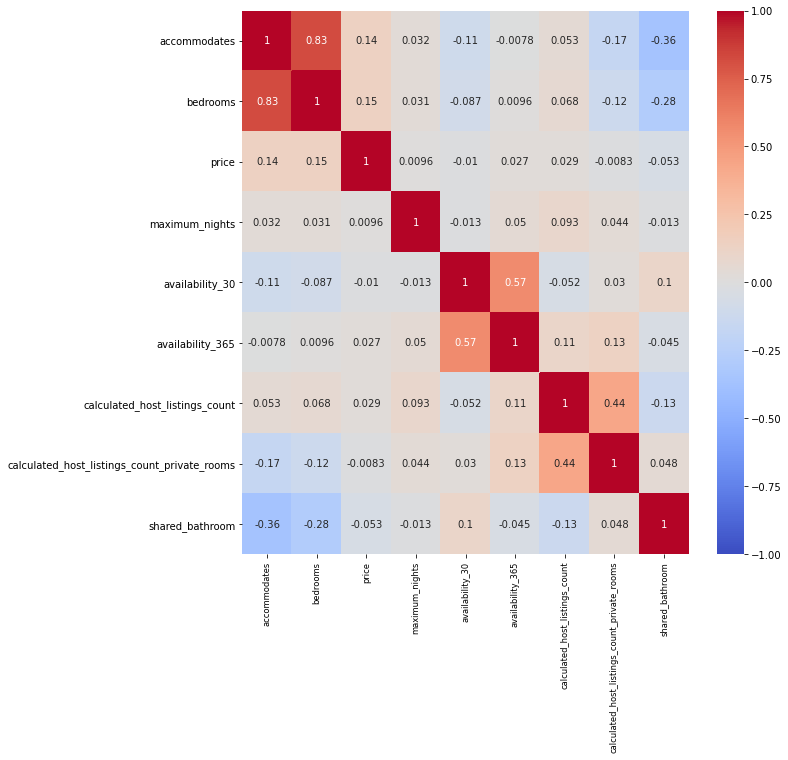

In [12]:
plt.figure(figsize=(10,10))
#Plot heatmap of correlations
fig = sns.heatmap(correlations,vmin=-1,
            cmap='coolwarm',
            annot=True
               )

fig.set_xticklabels(fig.get_xticklabels(), rotation=90,fontsize='small')
plt.savefig('Images/correlations.png')
plt.show()

## Outliers

### Examine Outliers via Boxplots 

C:\Users\Katya\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Katya\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Katya\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Katya\anaconda3\lib\si

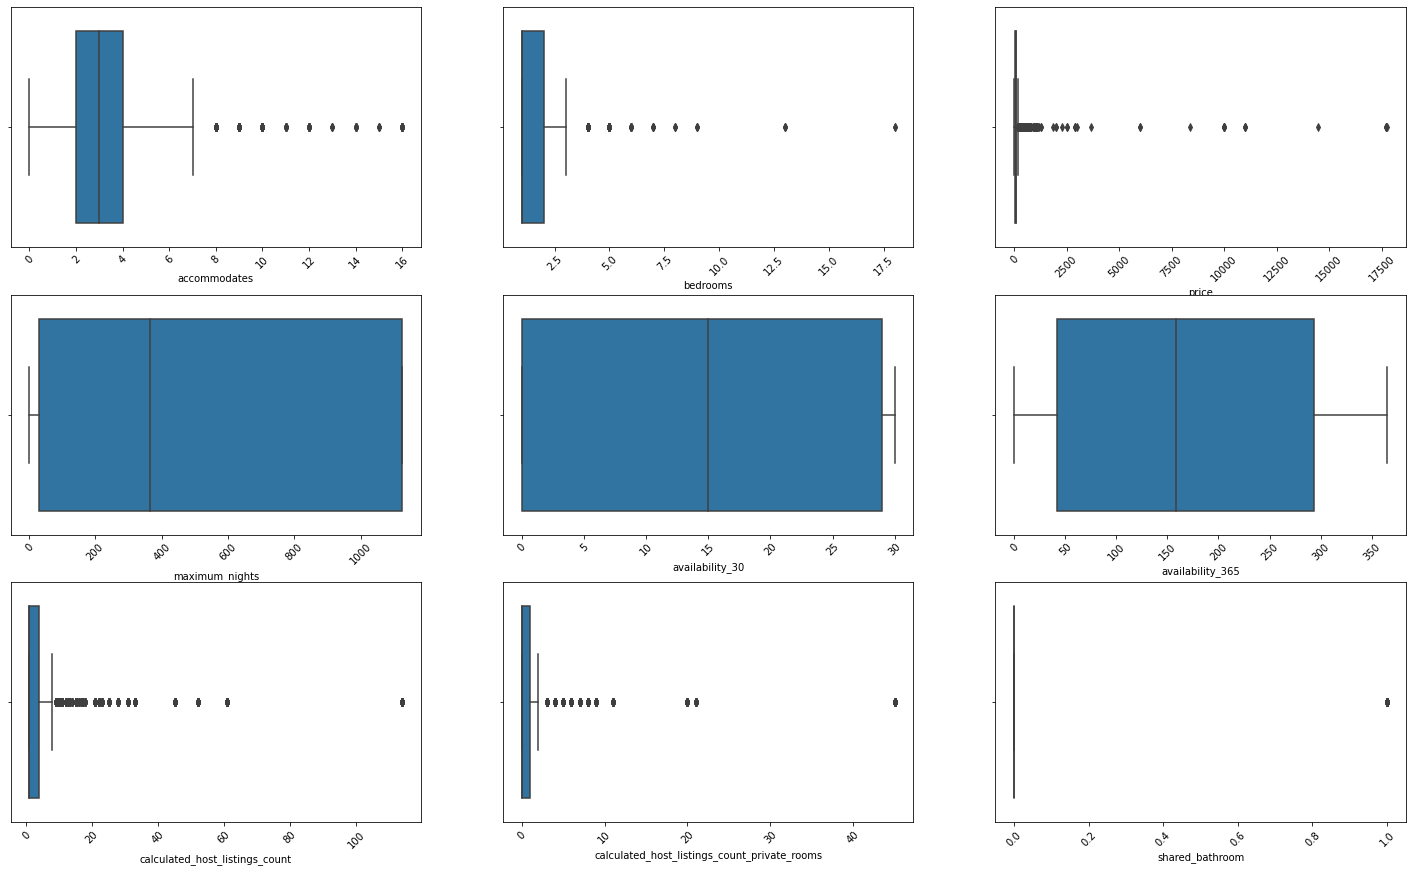

In [13]:
fig1, ax = plt.subplots(3, 3, figsize=(25,15))
for variable, subplot in zip(list_df.select_dtypes(include=['int64','float64']), ax.flatten()):
    sns.boxplot(list_df[variable], ax=subplot )
    for label in subplot.get_xticklabels():
        label.set_rotation(45)

In [14]:
# The distributions are not normal, so I'm using inter-quartile ranges to handle outliers: 
# values lower than the lower range or values higher than the upper range get dropped

for col in list_df.select_dtypes(include=['int64','float64']):
    Q1 = list_df[col].quantile(0.25)
    Q3 = list_df[col].quantile(0.75)
    IQR = Q3 - Q1
    
    lower = Q1 - (1.5 * IQR)
    upper = Q3 + (1.5 * IQR)

    list_df.drop(list_df[ (list_df[col] > upper) | (list_df[col] < lower) ].index , inplace=True)
   
# view results 
list_df.describe()      

,accommodates,bedrooms,price,maximum_nights,availability_30,availability_365,calculated_host_listings_count,calculated_host_listings_count_private_rooms,shared_bathroom
count,3431.00000,3348.00000,3431.00000,3431.00000,3431.00000,3431.00000,3431.00000,3431.00000,3422.00000
mean,3.50831,1.54570,79.92189,553.21306,14.13582,153.63363,1.57301,0.23404,0.00000
std,1.42995,0.64351,36.20294,516.62594,13.44663,127.47770,1.11018,0.51876,0.00000
min,0.00000,1.00000,0.00000,1.00000,0.00000,0.00000,1.00000,0.00000,0.00000
25%,2.00000,1.00000,52.00000,30.00000,0.00000,31.00000,1.00000,0.00000,0.00000
50%,4.00000,1.00000,72.00000,365.00000,14.00000,136.00000,1.00000,0.00000,0.00000
75%,4.00000,2.00000,100.00000,1125.00000,29.00000,265.00000,2.00000,0.00000,0.00000
max,7.00000,3.00000,185.00000,1125.00000,30.00000,365.00000,6.00000,2.00000,0.00000


array([[<AxesSubplot:title={'center':'accommodates'}>,
        <AxesSubplot:title={'center':'bedrooms'}>,
        <AxesSubplot:title={'center':'price'}>],
       [<AxesSubplot:title={'center':'maximum_nights'}>,
        <AxesSubplot:title={'center':'availability_30'}>,
        <AxesSubplot:title={'center':'availability_365'}>],
       [<AxesSubplot:title={'center':'calculated_host_listings_count'}>,
        <AxesSubplot:title={'center':'calculated_host_listings_count_private_rooms'}>,
        <AxesSubplot:title={'center':'shared_bathroom'}>]], dtype=object)

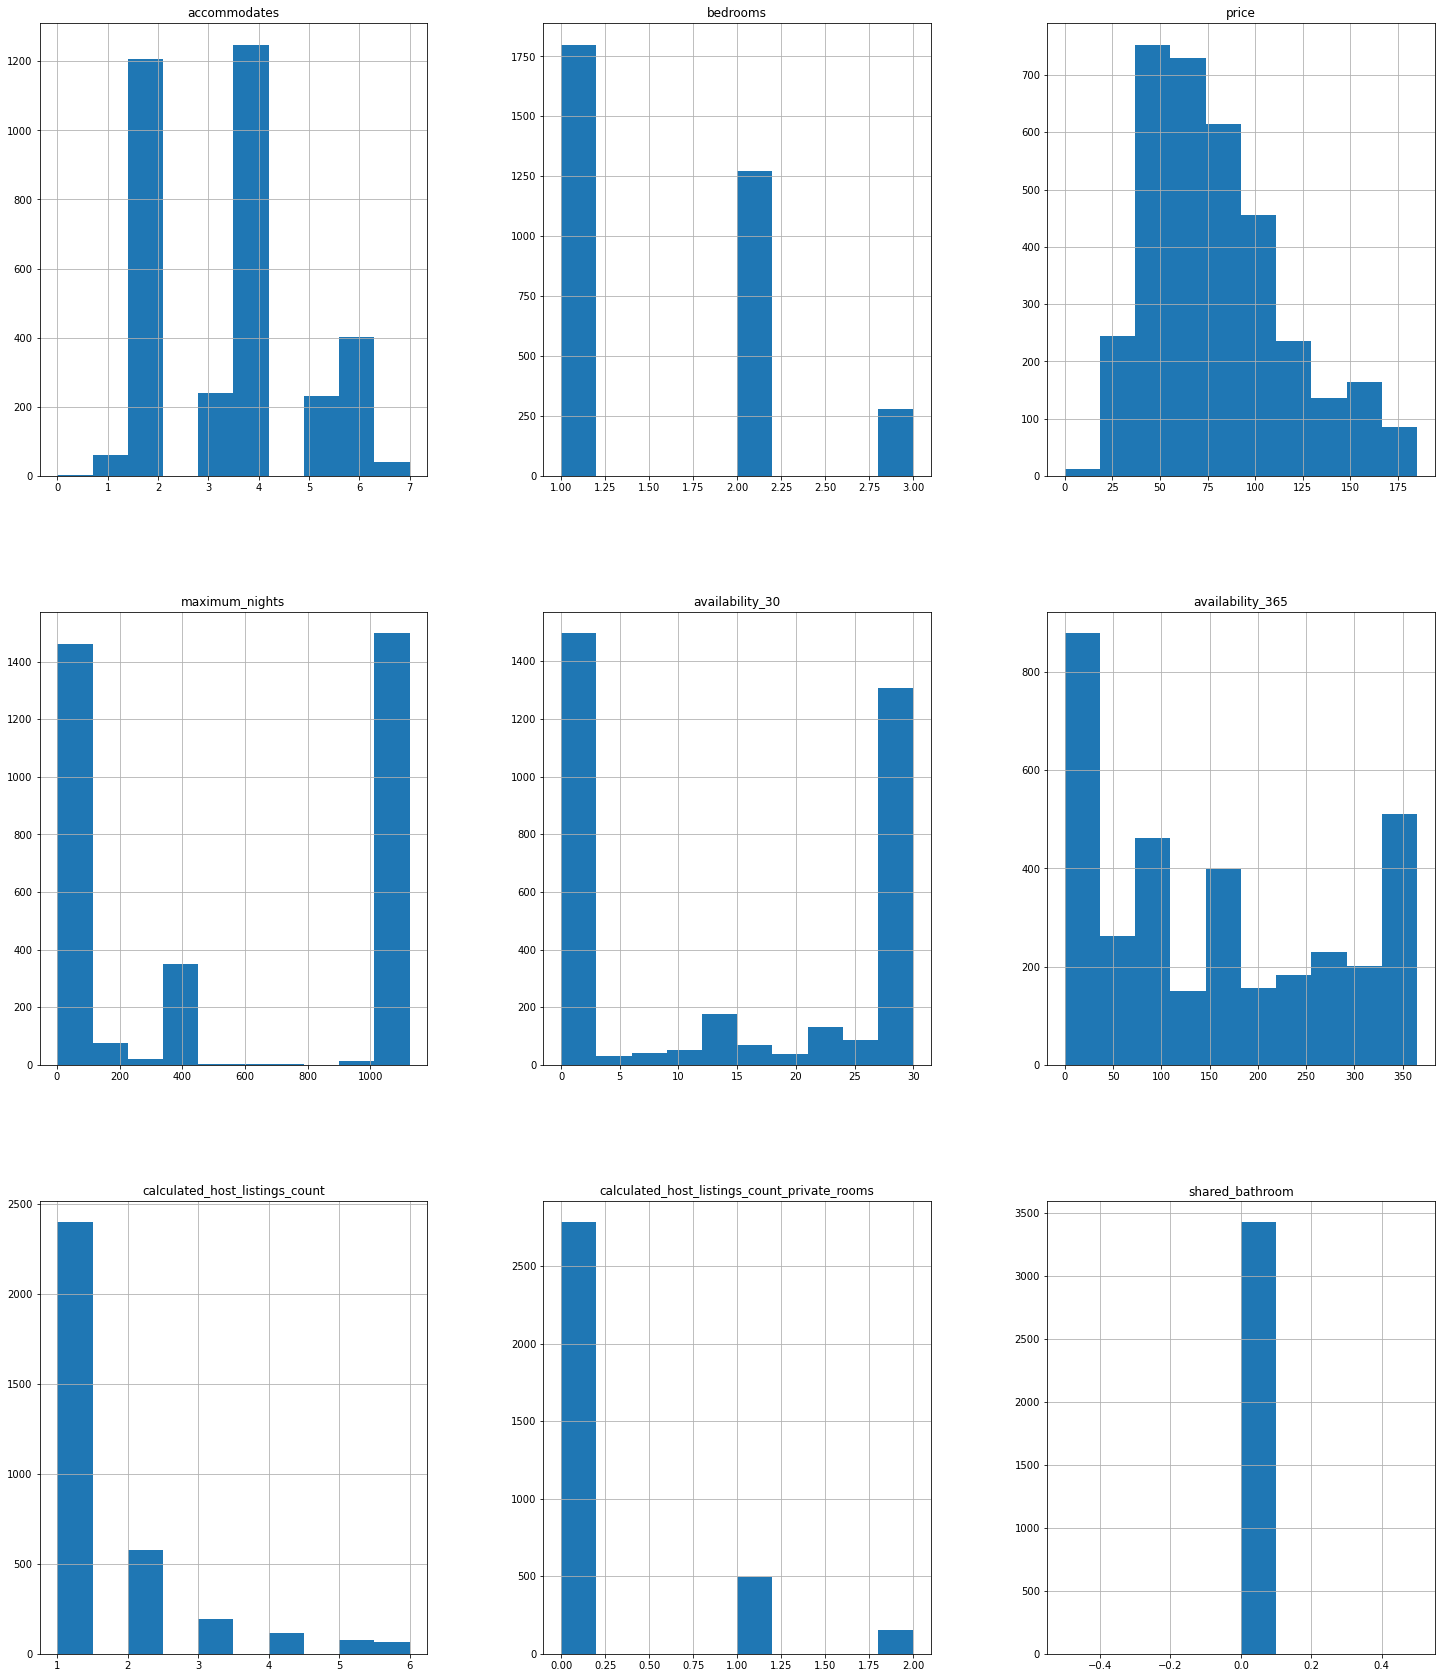

In [15]:
# Plot distributions again
list_df.hist(figsize = (25,30))

## Process 'amenities' feature

This is an important feature, in the original data a single string of list, containing funny characters. Here's how I'll process it: 

1. split the string feature into a list and remove non-word characters
2. group the amenities into larger groupings: e.g., stuff about soap, shower gel etc are bucketed together. This reduced then from 228 to 109 groupings. 
3. drop the infrequent new amenity groupings: those that occur less than 18% in the data (my cut off was child/baby friendly amenities). This is done to reduce the large number of features that will be produced when binarising the features. 
4. encode the amenity features into a binary format (using MultiLabelBinarizer)
5. append the binary amenity data frame to the list of features 


In [16]:
# function splitting amenities value and removing non-word strings 

def split_amenities(string_of_amenities):
    pattern = re.compile(r'\\u2019|\\u2013|\\u2014|\\u00a32|\\u00a33|\\u00a0|\["|"\]|\[\]|\\')
    string_of_amenities = re.sub(pattern, '', string_of_amenities)
    return string_of_amenities.split('", "')

list_df['amenities'] = list_df['amenities'].apply(split_amenities)

In [17]:
# print number of amenities before grouping

amenities = set([ amen for amen_lst in list_df['amenities'].tolist() for amen in amen_lst ]) 
print(len(amenities))

228


In [18]:
# function grouping amenities together into larger groups

def process_amenities(list_of_amenities):
    result = list()
    for amenity in list_of_amenities:
        if 'wifi' in amenity.lower():
            result.append('amenity_wifi')
        elif 'washer' in amenity.lower():
            result.append('amenity_washer')
        elif 'breakfast' in amenity.lower():
            result.append('amenity_breakfast')
        elif 'tv' in amenity.lower():
            result.append('amenity_tv')
        elif 'free parking' in amenity.lower() or 'free street parking' in amenity.lower() \
            or 'free carport' in amenity.lower() or 'free driveway' in amenity.lower() \
            or 'free residential garage' in amenity.lower():
            result.append('amenity_free parking')
        elif 'paid parking' in amenity.lower() or 'paid street parking' in amenity.lower():
            result.append('paid parking')
        elif 'clothing storage' in amenity.lower():
            result.append('amenity_clothing storage')
        elif 'body soap' in amenity.lower() or 'conditioner' in amenity.lower() \
            or 'toiletries' in amenity.lower() or 'shower gel' in amenity.lower() \
            or 'shampoo' in amenity.lower():
            result.append('amenity_toiletries')
        elif 'sound system' in amenity.lower():
            result.append('amenity_sound system')
        elif 'game console' in amenity.lower():
            result.append('amenity_game console')
        elif 'baby' in amenity.lower() or 'children' in amenity.lower() \
            or 'crib' in amenity.lower() or 'changing table' in amenity.lower() \
            or 'high chair' in amenity.lower():
            result.append('amenity_baby/child amenities')
        elif 'bed linen' in amenity.lower() or 'bed sheet' in amenity.lower():
            result.append('amenity_bed linen')
        elif 'oven' in amenity.lower() or 'stove' in amenity.lower():
            result.append('amenity_oven or stove')
        elif 'refrigerator' in amenity.lower() or 'fridge' in amenity.lower():
            result.append('amenity_fridge')
        elif 'dedicated workspace' in amenity.lower():
            result.append('amenity_dedicated workspace')
        elif 'dryer' in amenity.lower():
            result.append('amenity_dryer')
        elif 'gym' in amenity.lower() or 'fitness' in amenity.lower():
            result.append('amenity_gym')
        elif 'nespresso' in amenity.lower() or 'coffee' in amenity.lower():
            result.append('amenity_coffee facilities')
        else:
            result.append('amenity_'+amenity.lower())
    return result
        

In [19]:
list_df['amenities'] = list_df['amenities'].apply(process_amenities)


In [20]:
#print number of amenities after grouping

amenities = set([ amen for amen_lst in list_df['amenities'].tolist() for amen in amen_lst ]) 
print(len(amenities))

109


In [21]:
#encode the multilabel data in MLB Format

mlb = MultiLabelBinarizer()

amenities_bin_df = pd.DataFrame(mlb.fit_transform(list_df['amenities']), columns=mlb.classes_)

In [22]:
# drop least common amenities, along with original column 'amenities'
drop_amenities = [  ]

for col in amenities_bin_df.columns:
    # print(col, amenities_bin_df[col].sum(),amenities_bin_df[col].sum() / len(list_df) )
    if (amenities_bin_df[col].sum() / len(list_df) < 0.18):
         drop_amenities.append(col)
          

In [23]:
amenities_bin_df.drop(columns=drop_amenities,inplace=True)

In [24]:
# apend amenities binary df to the processed df
list_df = pd.concat([list_df, amenities_bin_df], axis=1, ignore_index=False)

## Categorical Features

The categorical features that are relevant for the model get encoded with the get_dummies method. 

In [25]:
dummies_df = pd.get_dummies(list_df[[
                                     'neighbourhood_cleansed', 
                                     'room_type', 
                                     'property_type' 
                                    ]])

In [26]:
# prepare final data: view shape & view head

list_final_df = pd.concat([list_df, dummies_df], axis=1, ignore_index=False)
list_final_df.drop(columns=['amenities',
                            'neighbourhood_cleansed', 
                            'room_type', 
                            'property_type', 
                            'bathrooms_text',
                            ],inplace=True)

#list_final_df = list_final_df.reset_index()

display(list_final_df.shape)
list_final_df.dropna(inplace=True)
display(list_final_df.shape)
display(list_final_df.head())

(4885, 198)

(1930, 198)

,accommodates,bedrooms,price,maximum_nights,availability_30,availability_365,calculated_host_listings_count,calculated_host_listings_count_private_rooms,shared_bathroom,amenity_baby/child amenities,...,property_type_Private room in villa,property_type_Room in aparthotel,property_type_Room in bed and breakfast,property_type_Room in boutique hotel,property_type_Room in hostel,property_type_Room in hotel,property_type_Room in serviced apartment,property_type_Shared room in apartment,property_type_Tiny house,property_type_Windmill
0,2.00000,1.00000,70.00000,30.00000,15.00000,310.00000,1.00000,0.00000,0.00000,1.00000,...,0,0,0,0,0,0,0,0,0,0
1,2.00000,1.00000,45.00000,120.00000,29.00000,356.00000,2.00000,0.00000,0.00000,0.00000,...,0,0,0,0,0,0,0,0,0,0
4,6.00000,3.00000,164.00000,28.00000,20.00000,301.00000,1.00000,0.00000,0.00000,0.00000,...,0,0,0,0,0,0,0,0,0,0
7,4.00000,1.00000,78.00000,31.00000,28.00000,238.00000,1.00000,0.00000,0.00000,1.00000,...,0,0,0,0,0,0,0,0,0,0
8,2.00000,1.00000,54.00000,1125.00000,4.00000,308.00000,1.00000,0.00000,0.00000,1.00000,...,0,0,0,0,0,0,0,0,0,0



# Modelling 

Moving to the modelling stage after having prepared the data. 

## Set target variable and features

In [27]:
target = 'price'
features = [ feat for feat in list_final_df.columns if feat != 'price' ]
X = list_final_df[features]
y = list_final_df[target]


## Split Train and Test Data

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42)

## Instantiate Models 

Here, I'm comparing three fairly different ML models:

1.  Linear regression models: Ridge and Lasso where each uses different regularisation technique for dealing with the data complexity. 
2. Multi-layer perceptron: a class of an artificial neural network. 
3. Random forest regressor: an ensemble method

In [29]:
# Instantiate models to try using k-fold validation. 

ridge = Ridge()
lasso = Lasso()
mlp = MLPRegressor(max_iter=500)
rf = RandomForestRegressor()

models = [ ('Ridge Regression', ridge),
           ('Lasso Regression', lasso),
           ('Multi-layer Perceptron', mlp), 
           ('Random Forest Regressor', rf)
         ]


## K-Fold Cross Validation

The data sample is fairly limited so k-fold cross validation will help getting a less biassed estimate of the model performance. 


In [30]:
# Run k-fold cross validation and print results for each model on training data 

model_results = []
for name, model in models:
    kfold = model_selection.KFold(n_splits=5)
    cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring='r2')
    model_results.append(cv_results)
    print("%s: %f (%f)" % (name, cv_results.mean(), cv_results.std()))

NameError: name 'model_selection' is not defined

### Model Fitting

In the above, the Random Forest Regressor is best, so this is the model I'll use for fitting the data. 

In [ ]:
rf.fit(X_train, y_train)

## Evaluation

In [ ]:
# Exploring results: make predictions on train and test and get scores

y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

r2_test = r2_score(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)

In [ ]:
r2_train = r2_score(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)

In [ ]:
scores_df = pd.DataFrame([{'Model':'Linear Regression', 
                           'R2 train': round(r2_train,4), 
                           'R2_test' : round(r2_test, 4),
                           'RMSE_train' : round(rmse_train, 4), 
                           'RMSE_test': round(rmse_test,4),
                          }])
scores_df

In [ ]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_test_pred})
df

## Feature Importances

In [ ]:
# extract feature importances

# we can also plot the importances graphically...

feat_ranks = pd.DataFrame(rf.feature_importances_ , X_train.columns).reset_index()
feat_ranks.columns=['Feature', 'Weight']
feat_ranks.sort_values(by='Weight',inplace=True,ascending=False)
feat_ranks

## Visually plotting top 15 features

In [ ]:
#plot=feat_ranks.nlargest(15,'Weight').plot(kind="barh") # as plot

import plotly.express as px
fig = px.bar(feat_ranks, x="Weight", y="Feature", )
fig.update_yaxes(range=(-.5, 19))
fig.show()
fig.write_image("Images/top_features.png")

## Visually plotting Neighbourhood-Feature Importances

In [ ]:
# filter data

feat_neighbourhoods = feat_ranks[feat_ranks.Feature.str.contains('neighbourhood')]
feat_neighbourhoods['Feature'] = feat_neighbourhoods['Feature'].str.split("_").str.get(2)
feat_neighbourhoods.head(10)

In [ ]:
fig = px.bar(feat_neighbourhoods, x="Weight", y="Feature", )
fig.update_yaxes(range=(-.5, 19))
fig.show()
fig.write_image("Images/top_neighbourhoods.png")

## Visually plotting Amenity-related Feature Importances

In [ ]:
# filter data

feat_amenity = feat_ranks[feat_ranks.Feature.str.contains('amenity_')]
feat_amenity['Feature'] = feat_amenity['Feature'].str.split("_").str.get(1)
feat_amenity.head(10)

In [ ]:
fig = px.bar(feat_amenity, x="Weight", y="Feature", )
fig.update_yaxes(range=(-.5, 19))
fig.show()
fig.write_image("Images/top_amenities.png")

## Visually plotting Property Type Feature Importances

In [ ]:
# filter data

feat_prop = feat_ranks[feat_ranks.Feature.str.contains('property_type')]
feat_prop['Feature'] = feat_ranks['Feature'].str.split("_").str.get(2)
feat_prop.head(10)

In [ ]:
fig = px.bar(feat_prop, x="Weight", y="Feature", )
fig.update_yaxes(range=(-.5, 19))
fig.show()
fig.write_image("Images/top_prop.png")